# Theoretical models fitted to flow curves

In this notebook I use the curve fitting function from Python SK-Learn package to apply rheological models to experimental data. The input data consist of a csv file with two columns corresponding to stress and strain rate measurements. 

This software calculates viscosity and fits several models to the flow curves. 

The output consists of two spreadsheets: 
- experimental data and stress values obtained from each fit
- scores for each fit and relative parameters values

Those shown here as an example are synthetic data

## 1. import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import curve fitting package from scipy
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from pandas import ExcelWriter

In [2]:
# import from csv containing stres and strain rate and delete eventual empty cells
df_ares = pd.read_csv('input_data.csv').dropna() 
#define viscosity. We calculate it rather than importing it from the instrument software
df_ares['Viscosity'] =  df_ares['Shear stress']/df_ares['Shear rate'] 
df_ares.head() #visualize input table

,Shear rate,Shear stress,Viscosity
0,2.000000,66.044951,33.022476
1,2.472529,71.833355,29.052583
2,3.054742,79.110979,25.897763
3,3.978503,88.388858,22.216613
4,4.998865,98.365375,19.677543


In [3]:
# extract numpy arrays from the dataframe columns
x1 = df_ares['Shear rate'].values
y_stress = df_ares['Shear stress'].values
y_visc = df_ares['Viscosity'].values

## 2. Modelling : equation coefficients calculation

equations from:
https://blog.rheosense.com/modeling-non-newtonian-fluids

### 2.1 Models for non-newtonian fluids

In [4]:
# Function to calculate the Ostwald de Waele (power law) model 
def power(x,  K, n):
    return K*x**(n-1)

# Function to calculate the Carreau model
# from https://en.wikipedia.org/wiki/Carreau_fluid
def Carreau(x ,eta0, eta_inf, L, n):
    return eta_inf + (eta0 - eta_inf)*(1 + (L*x)**2)**((n-1)/2)

# Function to calculate the Yasuda model
def Yasuda(x ,eta0, eta_inf, L, n,a):
    return (eta0-eta_inf) * ((1 + (L*x)**a)**((n-1)/a))

# Function to calculate the Cross model
def Cross(x ,eta0, eta_inf, k, n):
    return eta_inf + (eta0-eta_inf)/(1 +(k*x)**n)

In [5]:
def non_newtonian_fits(x,y):
    non_newtonian_models = [power, Carreau, Yasuda, Cross]
    model_param_list = []
    for model in non_newtonian_models:
        param, param_cov = curve_fit(model, x,y , maxfev=5000)
        model_param_list.append(np.round(param,2))
    return model_param_list

NonNewtonian_param_list = non_newtonian_fits(x1, y_visc)

NonNewtonian_param_list 

[array([41.55,  0.57]),
 array([72.59,  7.06, -1.44,  0.17]),
 array([ 20.68, -35.49,   2.02,   0.57,  11.11]),
 array([211.08,   7.15,   4.57,   0.87])]

In [6]:
#param1, param_cov = curve_fit(Carreau, x1, y_visc , maxfev=5000)
#NonNewtonian_param_list[1] = param1
#NonNewtonian_param_list

### 2.2 Models that assume that the fluid has a yield stress

In [7]:
# Function to calculate the Bingham model
def Bingham(x ,y0, pv):
    return y0 + pv*x
# https://glossary.oilfield.slb.com/en/terms/b/bingham_plastic_model
 
# Function to calculate the HB model
def Herschel_Bulkley(x ,y0, K, n):
    return (y0 + K*x**n)

# Function to calculate the HB model
def Casson(x ,yc, eta):
    return ((np.sqrt(yc) + np.sqrt(eta*x))**2)/1

In [8]:
def yield_stress_fits(x,y):
    yield_stress_models = [Bingham, Herschel_Bulkley, Casson]
    model_param_list = []
    for model in yield_stress_models:
        param, param_cov = curve_fit(model, x,y , maxfev=5000)
        model_param_list.append(np.round(param,2))
    return model_param_list

yield_stress_param_list = yield_stress_fits(x1, y_stress)

 

### 3. Modelling : viscosity values from each fit

In [9]:
# now let's calculate the viscosity values from the fit
eta_pow = NonNewtonian_param_list[0][0] * (x1**(NonNewtonian_param_list[0][1]-1))

# Carreau parameters

eta0 = NonNewtonian_param_list[1][0]
eta_inf = NonNewtonian_param_list[1][1]
L = NonNewtonian_param_list[1][2]
n = NonNewtonian_param_list[1][3]


eta_car = eta_inf + (eta0 - eta_inf)*(1 + (L*x1)**2)**((n-1)/2)

# Yasuda parameters
eta0 = NonNewtonian_param_list[2][0]
eta_inf = NonNewtonian_param_list[2][1]
L = NonNewtonian_param_list[2][2]
n = NonNewtonian_param_list[2][3]
a = NonNewtonian_param_list[2][4]

eta_yas = (eta0-eta_inf) * ((1 + (L*x1)**a)**((n-1)/a))
#cross parameters
c_eta0 = NonNewtonian_param_list[3][0]
c_eta_inf = NonNewtonian_param_list[3][1]
c_k = NonNewtonian_param_list[3][2]
c_n = NonNewtonian_param_list[3][3]

eta_cross = c_eta_inf + (c_eta0-c_eta_inf)/(1 +(c_k*x1)**c_n)

In [10]:
# now let's calculate the stress and viscosity values from the fit

y_bin = yield_stress_param_list[0][0] + yield_stress_param_list[0][1]*x1
eta_bin = y_bin/x1

y_hb =   yield_stress_param_list[1][0] + yield_stress_param_list[1][1]*x1**yield_stress_param_list[1][2]
eta_hb = y_hb/x1

y_cas = (np.sqrt(yield_stress_param_list[2][0]) + np.sqrt(yield_stress_param_list[2][1]*x1))**2
eta_cas = y_cas/x1

### 4. Models scores

In [11]:
def compare_models(eta_list):    
    MLA_names = []
    ExplVar_scores = [] # explained variance list
    MAE_scores = [] # mean average error list
    RMSE_scores = [] # root mean square error list
    R2_scores = [] # regression coefficients list
    MLA_names = ['Ostwald – de Waele power law', 'Carreau', 'Carreau-Yasuda', 'Cross', 'Bingham',"Herschel-Bulkley", 'Casson']
       
    for y_pred in eta_list:
                
        #model scores  
        R2 = r2_score(y_visc, y_pred)
        EV = explained_variance_score(y_visc, y_pred)
        MAE = mean_absolute_error(y_visc, y_pred)

        MSE = mean_squared_error(y_visc, y_pred)
        RMSE = np.sqrt(MSE)

        # add results to lists for a final comparison
               
        MAE_scores.append(round(MAE, 2))
        ExplVar_scores.append(round(EV, 2))
        RMSE_scores.append(round(RMSE, 2))
        R2_scores.append(round(R2, 4))
        
    
    #create table to compare MLA metrics
    MLA_columns = ['Model Name', 'Explained Variance','MAE', 'RMSE', 'R2']
    zippedList =  list(zip(MLA_names, ExplVar_scores, MAE_scores, RMSE_scores, R2_scores))
    df = pd.DataFrame(zippedList, columns = MLA_columns)#.sort_values(by=['R2'],ascending=False)
    return df

In [12]:
eta_list = [eta_pow, eta_car, eta_yas, eta_cross ,eta_bin, eta_hb, eta_cas]
df_results = compare_models(eta_list)

In [13]:
list_power =['K','n']
list_carreau = ['eta0',  'eta_inf','L', 'n']
list_yasuda = ['eta0', 'eta_inf', 'L', 'n','a']
list_cross = ['eta0', 'eta_inf', 'k', 'n']
list_bingham = ['yield_stress', 'plastic viscosity']
list_hb = ['yield_stress', 'K', 'n']
list_casson = ['yield_stress','casson_viscosity']

models_name_list = ['Ostwald – de Waele power law', 'Carreau', 'Carreau-Yasuda', 'Cross', 'Bingham',"Herschel-Bulkley", 'Casson']
coefficient_list = [list_power, list_carreau, list_yasuda, list_cross, list_bingham, list_hb, list_casson]


In [14]:
df_final = df_ares

for i in range(len(models_name_list)):
    name = "%s_viscosity" % models_name_list[i]
    df_final[name] = eta_list[i]

df_final

,Shear rate,Shear stress,Viscosity,Ostwald – de Waele power law_viscosity,Carreau_viscosity,Carreau-Yasuda_viscosity,Cross_viscosity,Bingham_viscosity,Herschel-Bulkley_viscosity,Casson_viscosity
0,2.000000,66.044951,33.022476,30.840977,33.039351,30.814877,33.110987,39.035000,35.145331,29.594894
1,2.472529,71.833355,29.052583,28.152711,29.191320,28.128886,29.209794,33.021673,30.201274,26.358153
2,3.054742,79.110979,25.897763,25.705851,25.826734,25.684097,25.842758,28.170759,26.186923,23.614809
3,3.978503,88.388858,22.216613,22.945185,22.259271,22.925767,22.289029,23.387508,22.193237,20.746951
4,4.998865,98.365375,19.677543,20.799665,19.692546,20.782062,19.730071,20.158858,19.466367,18.681347
5,6.246547,109.289774,17.496029,18.899304,17.589413,18.883310,17.627105,17.644365,17.315045,16.968808
6,7.945852,124.144791,15.623849,17.041610,15.699951,17.027188,15.731454,15.489855,15.441708,15.399278
7,9.967245,141.157305,14.162118,15.459083,14.226534,15.446000,14.249140,13.883680,14.017062,14.142594
8,12.609521,163.332623,12.953119,13.972388,12.960294,13.960563,12.973237,12.560673,12.815265,13.028496
9,15.820988,189.006329,11.946557,12.673617,11.949771,12.662892,11.954698,11.547628,11.868100,12.107372


## 5. Output files

In [15]:
output_name = input("Enter output file name: ")
print(output_name)

Enter output file name: try
try


In [16]:
l1 = NonNewtonian_param_list
l2 = yield_stress_param_list

parameters_values = [*l1, *l2]#.append()
parameters_values

[array([41.55,  0.57]),
 array([72.59,  7.06, -1.44,  0.17]),
 array([ 20.68, -35.49,   2.02,   0.57,  11.11]),
 array([211.08,   7.15,   4.57,   0.87]),
 array([62.93,  7.57]),
 array([50.19, 10.55,  0.93]),
 array([18.51,  5.75])]

In [17]:
param_zippedList =  list(zip(models_name_list, coefficient_list, parameters_values))
df_param = pd.DataFrame(param_zippedList, columns = ['model','coefficient','value'])
df_param

,model,coefficient,value
0,Ostwald – de Waele power law,"[K, n]","[41.55, 0.57]"
1,Carreau,"[eta0, eta_inf, L, n]","[72.59, 7.06, -1.44, 0.17]"
2,Carreau-Yasuda,"[eta0, eta_inf, L, n, a]","[20.68, -35.49, 2.02, 0.57, 11.11]"
3,Cross,"[eta0, eta_inf, k, n]","[211.08, 7.15, 4.57, 0.87]"
4,Bingham,"[yield_stress, plastic viscosity]","[62.93, 7.57]"
5,Herschel-Bulkley,"[yield_stress, K, n]","[50.19, 10.55, 0.93]"
6,Casson,"[yield_stress, casson_viscosity]","[18.51, 5.75]"


In [18]:
df_results = pd.merge(df_param, df_results, left_on='model', right_on='Model Name')
df_results = df_results.drop(['Model Name'], axis=1)
df_results

,model,coefficient,value,Explained Variance,MAE,RMSE,R2
0,Ostwald – de Waele power law,"[K, n]","[41.55, 0.57]",0.97,1.10,1.27,0.9709
1,Carreau,"[eta0, eta_inf, L, n]","[72.59, 7.06, -1.44, 0.17]",1.00,0.04,0.05,0.9999
2,Carreau-Yasuda,"[eta0, eta_inf, L, n, a]","[20.68, -35.49, 2.02, 0.57, 11.11]",0.97,1.10,1.27,0.9709
3,Cross,"[eta0, eta_inf, k, n]","[211.08, 7.15, 4.57, 0.87]",1.00,0.06,0.07,0.9999
4,Bingham,"[yield_stress, plastic viscosity]","[62.93, 7.57]",0.95,0.92,1.82,0.9405
5,Herschel-Bulkley,"[yield_stress, K, n]","[50.19, 10.55, 0.93]",0.99,0.28,0.58,0.9939
6,Casson,"[yield_stress, casson_viscosity]","[18.51, 5.75]",0.98,0.72,1.25,0.9721


In [19]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter("%s_output.xlsx" % output_name, engine='xlsxwriter')

In [20]:
# Convert the dataframe to an XlsxWriter Excel object.
df_final.to_excel(writer, sheet_name='data')
df_results.to_excel(writer, sheet_name='results')

# Close the Pandas Excel writer and output the Excel file.

writer.save()

Finally let's plot the results

In [21]:
print('Visualize the chosen model fit')
for i in range(len(models_name_list)):
    print(i,':',models_name_list[i])

Visualize the chosen model fit
0 : Ostwald – de Waele power law
1 : Carreau
2 : Carreau-Yasuda
3 : Cross
4 : Bingham
5 : Herschel-Bulkley
6 : Casson


In [28]:
model_number = input("Enter the number corresponding to the model: ")
num = int(model_number)

Enter the number corresponding to the model: 1


Text(0.5, 0, 'Shear Rate [1/s]')

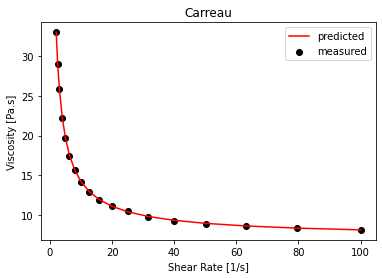

In [29]:
print('')
plt.scatter(df_ares['Shear rate'],df_ares['Viscosity'], color = 'k', label = 'measured')
plt.plot(x1, eta_list[num], color = 'r', label = 'predicted')

plt.title(models_name_list[num])
#plt.xscale('log')
#plt.yscale('log')
plt.legend()

plt.ylabel('Viscosity [Pa.s]')
plt.xlabel('Shear Rate [1/s]')

 